<a href="https://colab.research.google.com/github/sdgroeve/Machine_Learning_course_UGent_D012554_2025/blob/main/notebooks/Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Methods for Leukemia Classification using Nested Cross-Validation

This notebook demonstrates how ensemble methods, specifically **blending** (soft voting) and **stacking**, can improve classification performance compared to individual models on a high-dimensional gene-expression dataset. We use the classic **Golub leukemia dataset** and employ **nested cross-validation** for robust performance evaluation and hyperparameter tuning.

### 1 | Objectives & Road-map

*   **Task:** Classify leukemia sub-types (ALL vs. AML) from genome-wide mRNA expression data.
*   **Data:** Golub et al., 1999 – 72 patients × 7,129 gene probes.
*   **Demonstration Goal:** Show that carefully tuned blending and stacking ensembles, assessed with nested CV, provide a statistically significant performance lift over the best single, tuned model.

### 2 | Environment Setup

Import necessary libraries for data handling, modeling, evaluation, and visualization.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Data fetching
from sklearn.datasets import fetch_openml

# Preprocessing and Feature Selection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA # For EDA

# Model Selection and Evaluation
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer

# Base Learners
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Ensemble Methods
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Statistical Testing
from scipy import stats

# Configure plots and warnings
%matplotlib inline
sns.set_style('whitegrid')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning) # Ignore common warnings from sklearn/seaborn

### 3 | Load the Golub Gene-Expression Data

We fetch the data directly from OpenML using its `data_id`. The original dataset has multiple subtypes of Acute Lymphoblastic Leukemia (ALL). For this demonstration, we simplify the task to a binary classification problem: ALL vs. Acute Myeloid Leukemia (AML).

In [54]:
# Fetch data (features X, target y)
# Setting parser='liac-arff' to avoid potential loading issues
X, y = fetch_openml(data_id=1432, as_frame=False, return_X_y=True, parser='liac-arff')
X = X.toarray()

# Original shape
print(f"Original data shape: {X.shape}") # (samples, features)

# Binarize the target variable: Combine ALL subtypes
#y = np.array([ 'ALL' if label in ['allB', 'allT'] else 'AML' for label in y ])

# Display class distribution
print("\nClass distribution after binarization:")
unique, counts = np.unique(y, return_counts=True)
class_dist = dict(zip(unique, counts))
print(class_dist)

Original data shape: (62, 2000)

Class distribution after binarization:
{np.float64(-1.0): np.int64(40), np.float64(1.0): np.int64(22)}


### 4 | Quick EDA & Sanity Checks

Let's perform some basic exploratory data analysis:
1.  **Class Distribution:** Check if the classes are reasonably balanced.
2.  **Feature Variance:** Examine the variance of gene expression values. Many genes might have very low variance across patients, indicating they might not be informative.
3.  **PCA Visualization:** Use Principal Component Analysis (PCA) to reduce dimensionality to 2D and visualize potential separation between the classes.

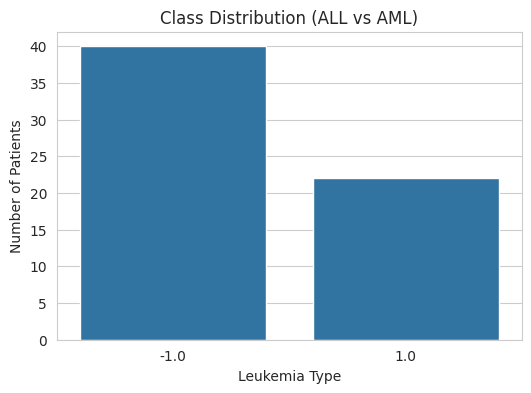

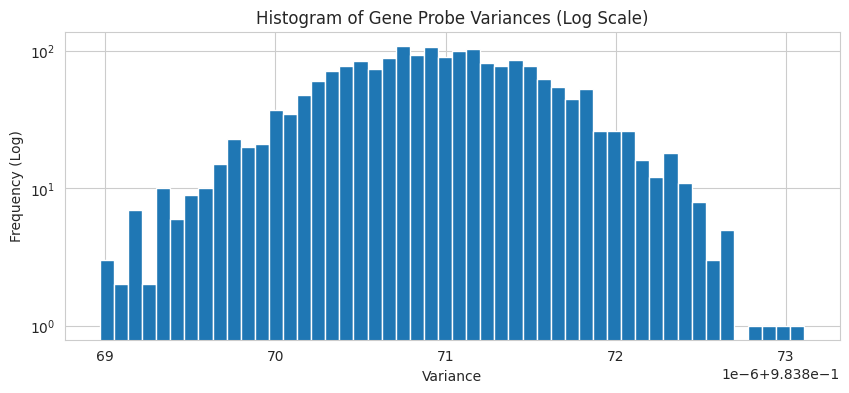

Number of features with zero variance: 0
Median variance: 0.9839


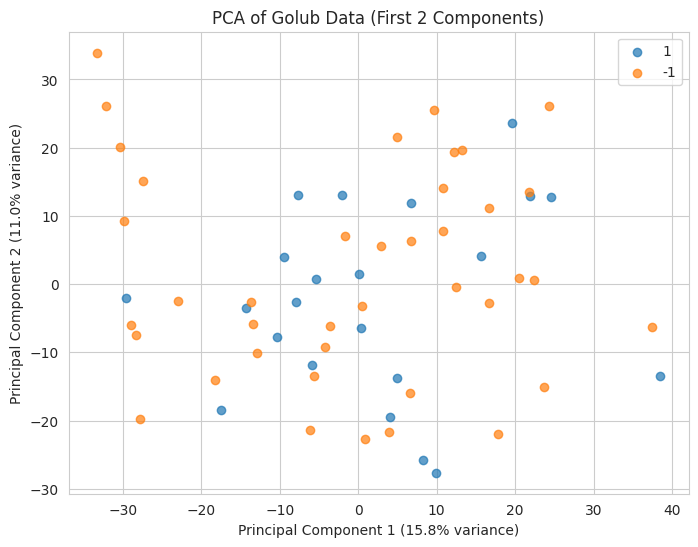


EDA Findings:
- Classes are somewhat imbalanced (approx 2/3 ALL, 1/3 AML). Stratified sampling is important.
- Many gene probes have very low variance, supporting the use of VarianceThreshold.
- PCA shows some separation between classes, suggesting classification is feasible.


In [55]:
# 1. Class Distribution (already printed above)
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Class Distribution (ALL vs AML)')
plt.xlabel('Leukemia Type')
plt.ylabel('Number of Patients')
plt.show()

# 2. Feature Variance Histogram
variances = np.var(X, axis=0)
plt.figure(figsize=(10, 4))
plt.hist(variances, bins=50, log=True)
plt.title('Histogram of Gene Probe Variances (Log Scale)')
plt.xlabel('Variance')
plt.ylabel('Frequency (Log)')
plt.show()
print(f"Number of features with zero variance: {np.sum(variances == 0)}")
print(f"Median variance: {np.median(variances):.4f}")

# 3. PCA Scatter Plot
# Scale data first for PCA
scaler_eda = StandardScaler()
X_scaled_eda = scaler_eda.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_eda)

plt.figure(figsize=(8, 6))
for leukemia_type in [1,-1]:
    plt.scatter(X_pca[y == leukemia_type, 0],
                X_pca[y == leukemia_type, 1],
                label=leukemia_type,
                alpha=0.7)
plt.title('PCA of Golub Data (First 2 Components)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.legend()
plt.show()

print("\nEDA Findings:")
print("- Classes are somewhat imbalanced (approx 2/3 ALL, 1/3 AML). Stratified sampling is important.")
print("- Many gene probes have very low variance, supporting the use of VarianceThreshold.")
print("- PCA shows some separation between classes, suggesting classification is feasible.")

### 5 | Pre-processing Pipeline for p ≫ n Genomics

High-dimensional data (p=7129 features >> n=72 samples) is prone to overfitting and the curse of dimensionality. We define a standard preprocessing pipeline:

1.  **`VarianceThreshold`**: Removes features with zero variance.
2.  **`SelectKBest`**: Selects the top `k` features most correlated with the target variable using the ANOVA F-statistic (`f_classif`). We choose `k=500` as a balance between retaining signal and reducing dimensionality.
3.  **`StandardScaler`**: Standardizes features by removing the mean and scaling to unit variance.

In [56]:
preprocess = Pipeline([
    ('vt', VarianceThreshold(threshold=0.0)),        # Drop zero-variance probes
    ('kbest', SelectKBest(f_classif, k=500)),        # Keep top 500 informative genes
    ('scale', StandardScaler())
])

### 6 | Nested Cross-Validation Design

To get an unbiased estimate of model generalization performance and avoid information leakage during hyperparameter tuning, we use nested cross-validation (CV).

*   **Outer Loop:** Splits the data into K folds (e.g., 5). Each fold serves as a final test set *once*. The performance metrics reported are the average across these K test sets. This estimates the model's performance on unseen data.
    *   We use `StratifiedKFold` to maintain class proportions in each fold, important given the class imbalance.
*   **Inner Loop:** Performed *within each training split* of the outer loop. Its purpose is to find the best hyperparameters for the model using only the inner loop's training data. `GridSearchCV` is commonly used here.

> **Why nested?** Tuning hyperparameters and evaluating the model on the *same* CV folds leads to optimistic bias. Nested CV ensures that the final evaluation is performed on data completely unseen during hyperparameter optimization.

In [57]:
# Define the outer cross-validation strategy
OUTER_CV_SPLITS = 5
SEED = 42 # for reproducibility

outer_cv = StratifiedKFold(n_splits=OUTER_CV_SPLITS, shuffle=True, random_state=SEED)

# Define the inner cross-validation strategy (used by GridSearchCV)
INNER_CV_SPLITS = 3
inner_cv = StratifiedKFold(n_splits=INNER_CV_SPLITS, shuffle=True, random_state=SEED)

### 7 | Candidate Base Models & Parameter Grids

We select a few standard classifiers as base learners. For each, we define a hyperparameter grid to be searched by `GridSearchCV` in the inner loop. The parameter names in the grid must follow the convention `step_name__parameter_name`. Since our models will be inside a pipeline with the name `clf`, the parameter names become `clf__<param_name>`.

In [58]:
base_models = {
    'logreg': {
        'model': LogisticRegression(max_iter=5000, random_state=SEED, solver='liblinear'), # liblinear good for smaller datasets
        'grid': {'clf__C': [0.1, 1, 10]}
    },
    'svm': {
        'model': SVC(kernel='linear', probability=True, random_state=SEED),
        'grid': {'clf__C': [0.1, 1, 10]}
    },
    'rf': {
        'model': RandomForestClassifier(random_state=SEED),
        'grid': {'clf__n_estimators': [10, 50, 100],
                 'clf__max_features': ['sqrt', 0.3]}
  }
}

### 8 | Ensemble Strategy #1 – Soft Blending (VotingClassifier)

Blending averages the predictions (ideally probabilities, known as 'soft voting') of multiple base models. This often reduces variance and improves robustness.

We will create a `VotingClassifier` using the *best performing* base models identified after running the initial nested CV. For simplicity in this setup, we will pre-select Logistic Regression, SVM, and Random Forest based on common performance characteristics, but a more rigorous approach might dynamically select the top N models based on the inner CV scores from the first phase.

**Note:** Tuning hyperparameters *within* a VotingClassifier using GridSearchCV requires prefixing parameters with `estimatorname__parameter`. We will define the VotingClassifier using the base model *types* and let the `GridSearchCV` within the nested loop tune their parameters simultaneously.

In [59]:
# Define the base estimators for the VotingClassifier
# We use the same model instances defined earlier, but give them unique names for the ensemble
clf1 = LogisticRegression(max_iter=5000, random_state=SEED, solver='liblinear')
clf2 = SVC(kernel='linear', probability=True, random_state=SEED)
clf3 = RandomForestClassifier(random_state=SEED)

voting_clf = VotingClassifier(
    estimators=[('logreg_vote', clf1), ('svm_vote', clf2), ('rf_vote', clf3)],
    voting='soft' # Use predicted probabilities
)

# Define the parameter grid for tuning the models *inside* the VotingClassifier
# Note the prefixes matching the estimator names above
voting_grid = {
    'clf__logreg_vote__C': [0.1, 1, 10],          # Reduced grid for speed
    'clf__svm_vote__C': [0.1, 1, 10],             # Reduced grid for speed
    'clf__rf_vote__n_estimators': [10, 50, 100],    # Reduced grid for speed
    'clf__rf_vote__max_features': ['sqrt', 0.3]
    # We could also tune voting weights if desired, e.g., 'clf__weights': [...]
}

# Add to our dictionary of models to evaluate
ensemble_models = {
    'blend': {
        'model': voting_clf,
        'grid': voting_grid
    }
}

### 9 | Ensemble Strategy #2 – Stacking (level-1 meta-learner)

Stacking uses the predictions of base models (level-0) as input features for a final meta-learner (level-1), which makes the final prediction. `StackingClassifier` handles the generation of these 'meta-features' internally using cross-validation to prevent leakage.

We'll use the same base models as in blending and a `LogisticRegression` as the meta-learner. Similar to the `VotingClassifier`, we define the structure and the parameter grid for tuning the base learners *within* the stack.

In [60]:
# Define base estimators for StackingClassifier (can be the same instances)
# IMPORTANT: StackingClassifier clones estimators, so use the definitions
estimators_stack = [
    ('logreg_stack', LogisticRegression(max_iter=5000, random_state=SEED, solver='liblinear')),
    ('svm_stack', SVC(kernel='linear', probability=True, random_state=SEED)),
    ('rf_stack', RandomForestClassifier(random_state=SEED))
]

stacking_clf = StackingClassifier(
    estimators=estimators_stack,
    final_estimator=LogisticRegression(max_iter=2000), # Meta-learner
    cv=inner_cv,           # Use same inner CV strategy for generating meta-features
    stack_method='predict_proba', # Use probabilities as meta-features
    passthrough=False      # Only use meta-features for final estimator
)

# Define the parameter grid for tuning models *inside* the StackingClassifier
stacking_grid = {
    'clf__logreg_stack__C': [0.1, 1, 10],         # Reduced grid
    'clf__svm_stack__C': [0.1, 1, 10],            # Reduced grid
    'clf__rf_stack__n_estimators': [10, 50, 100],   # Reduced grid
    'clf__rf_stack__max_features': ['sqrt',0.3],
    # We could also tune the final_estimator's parameters, e.g.:
    'clf__final_estimator__C': [0.1, 1, 10]
}

# Add to our dictionary
ensemble_models['stack'] = {
    'model': stacking_clf,
    'grid': stacking_grid
}

### 10 | Running the Nested Loop & Collecting Scores

Now we run the nested cross-validation loop for all base models and the two ensemble strategies.

For each model:
1.  Create a full pipeline: `preprocessing + classifier`.
2.  Define the inner `GridSearchCV` to tune the hyperparameters defined in the grids.
3.  Use `cross_validate` with the `outer_cv` strategy. It takes the `GridSearchCV` object as the estimator.
    *   Inside each outer fold, `cross_validate` first calls `fit` on the `GridSearchCV` object using the outer *training* data. This triggers the inner CV loop to find the best parameters for that specific outer fold's training data.
    *   `GridSearchCV` automatically refits a model using the *best found parameters* on the *entire* outer training set.
    *   `cross_validate` then evaluates this refitted model on the outer *test* set.
4.  We collect the test scores (ROC AUC) from each of the outer folds. We also `return_estimator=True` to potentially inspect the models trained on each outer fold later.

In [61]:
# Define the scoring metric (Area Under the ROC Curve, OvR for multi-class if needed)
# For binary classification, 'roc_auc' is sufficient. needs_proba=True is crucial for AUC.
metric = 'roc_auc'

# Combine base models and ensembles for iteration
all_models_to_run = {**base_models, **ensemble_models}

nested_results = {}
trained_estimators = {}

print(f"Starting Nested Cross-Validation (Outer folds={OUTER_CV_SPLITS}, Inner folds={INNER_CV_SPLITS})...")

for name, spec in all_models_to_run.items():
    print(f"\nProcessing: {name}")

    # Create the full pipeline including preprocessing and the classifier
    pipeline = Pipeline([
        ('prep', preprocess),
        ('clf', spec['model'])
    ])

    # Inner loop: GridSearchCV for hyperparameter tuning
    # If grid is empty (e.g., simple avg voting), skip GridSearchCV
    if spec['grid']:
        inner_search = GridSearchCV(
            estimator=pipeline,
            param_grid=spec['grid'],
            cv=inner_cv,
            scoring=metric,
            n_jobs=-1 # Use all available CPU cores
        )
    else:
        # If no grid search needed, the pipeline itself is the estimator
        inner_search = pipeline
        print(f"  (Skipping GridSearchCV for {name})")

    # Outer loop: cross_validate to get generalization score
    cv_output = cross_validate(
        estimator=inner_search, # Pass the GridSearchCV object here
        X=X,
        y=y,
        cv=outer_cv,
        scoring=metric,
        n_jobs=-1,
        return_estimator=True, # Return the fitted estimator for each outer fold
        error_score='raise' # See errors during CV
    )

    # Store results
    nested_results[name] = cv_output['test_score']
    trained_estimators[name] = cv_output['estimator'] # List of estimators, one per outer fold

    print(f"  Finished. Mean ROC AUC: {np.mean(cv_output['test_score']):.4f} (+/- {np.std(cv_output['test_score']):.4f})")

print("\nNested Cross-Validation Complete.")

Starting Nested Cross-Validation (Outer folds=5, Inner folds=3)...

Processing: logreg
  Finished. Mean ROC AUC: 0.8600 (+/- 0.0834)

Processing: svm
  Finished. Mean ROC AUC: 0.8637 (+/- 0.0497)

Processing: rf
  Finished. Mean ROC AUC: 0.9000 (+/- 0.0983)

Processing: blend
  Finished. Mean ROC AUC: 0.8600 (+/- 0.0830)

Processing: stack
  Finished. Mean ROC AUC: 0.8725 (+/- 0.0800)

Nested Cross-Validation Complete.


### 11 | Visualising & Testing Performance Gains

Now we visualize the distribution of ROC AUC scores obtained from the outer loop for each model using a box plot. This helps compare both the average performance and the variability.

We then perform a statistical test to check if the performance difference between the best single model and the ensemble methods (specifically stacking, often the best performer) is statistically significant.


Mean ROC AUC scores across outer folds:
rf        0.90000
stack     0.87250
svm       0.86375
logreg    0.86000
blend     0.86000
dtype: float64


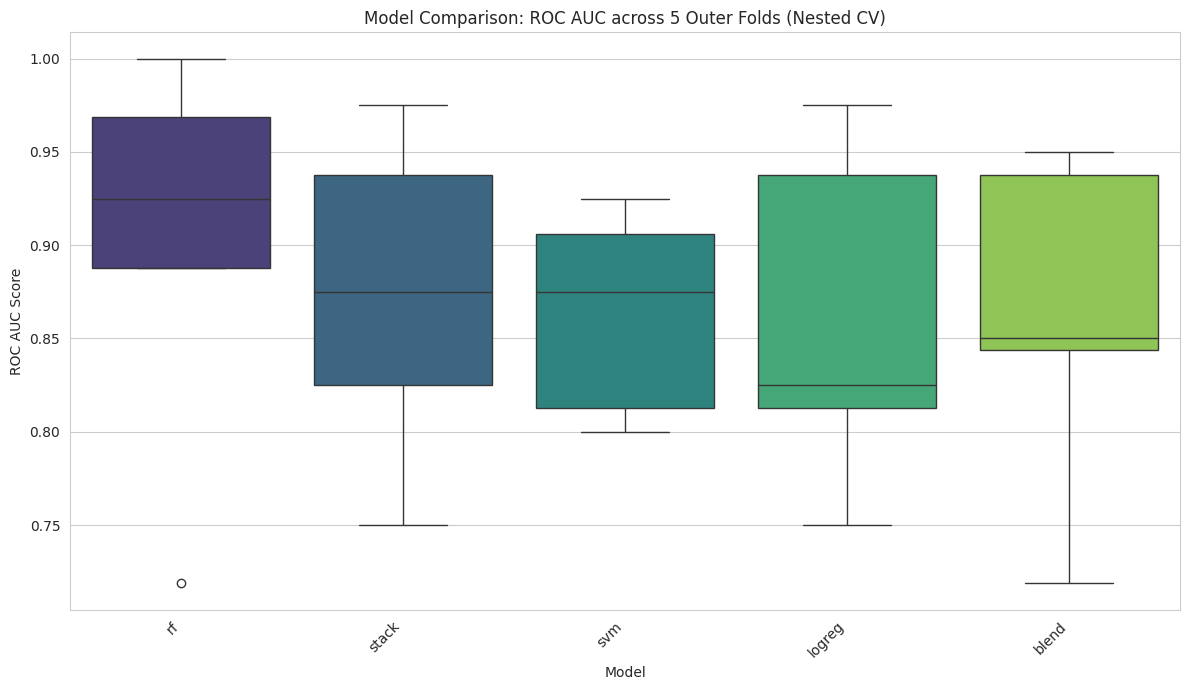


Comparing best single model ('rf') vs. Stacking Ensemble:
  Paired t-test: t-statistic = -0.963, p-value = 0.3899
  Wilcoxon signed-rank test: W-statistic = 3.000, p-value = 0.3125
  Conclusion (t-test): No statistically significant difference found between stacking and rf (p >= 0.05).


In [62]:
# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(nested_results)

# Calculate mean scores for ranking
mean_scores = results_df.mean().sort_values(ascending=False)
print("\nMean ROC AUC scores across outer folds:")
print(mean_scores)

# Create box plot
plt.figure(figsize=(12, 7))
sns.boxplot(data=results_df[mean_scores.index], palette='viridis') # Order by mean score
plt.title(f'Model Comparison: ROC AUC across {OUTER_CV_SPLITS} Outer Folds (Nested CV)')
plt.ylabel('ROC AUC Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Statistical Test: Compare best single model vs. stacking
# Identify best single model (excluding ensembles)
base_model_names = list(base_models.keys())
best_single_model_name = results_df[base_model_names].mean().idxmax()
best_single_model_scores = results_df[best_single_model_name]

# Get stacking scores
stacking_scores = results_df['stack']

print(f"\nComparing best single model ('{best_single_model_name}') vs. Stacking Ensemble:")

# Check if scores are valid for testing
if stacking_scores.isnull().any() or best_single_model_scores.isnull().any():
    print("  Skipping statistical test due to NaN scores.")
else:
    # Paired t-test (assumes normality, reasonable for AUC scores over ~5 folds)
    # Alternatives: Wilcoxon signed-rank test (non-parametric)
    t_stat, p_value_ttest = stats.ttest_rel(stacking_scores, best_single_model_scores)
    print(f"  Paired t-test: t-statistic = {t_stat:.3f}, p-value = {p_value_ttest:.4f}")

    # Wilcoxon signed-rank test
    try:
      # The wilcoxon test requires differences not all be zero. Check first.
      diff = stacking_scores - best_single_model_scores
      if np.all(diff == 0):
          print("  Wilcoxon test not applicable: all score differences are zero.")
      else:
          w_stat, p_value_wilcoxon = stats.wilcoxon(stacking_scores, best_single_model_scores)
          print(f"  Wilcoxon signed-rank test: W-statistic = {w_stat:.3f}, p-value = {p_value_wilcoxon:.4f}")
    except ValueError as e:
        # Handle cases like zero differences if not caught above
        print(f"  Could not perform Wilcoxon test: {e}")

    # Interpretation (using alpha = 0.05)
    alpha = 0.05
    if p_value_ttest < alpha:
        print(f"  Conclusion (t-test): Stacking performance ({stacking_scores.mean():.4f}) is statistically significantly different from {best_single_model_name} ({best_single_model_scores.mean():.4f}) (p < {alpha}).")
        if stacking_scores.mean() > best_single_model_scores.mean():
             print("    Stacking performance is significantly higher.")
        else:
             print("    Stacking performance is significantly lower (unexpected)." ) # Should check this
    else:
        print(f"  Conclusion (t-test): No statistically significant difference found between stacking and {best_single_model_name} (p >= {alpha}).")

### 12 | Interpreting the Stacked Model

If stacking performed well, we can gain some insight by examining the coefficients of the final meta-learner (`final_estimator_`). These coefficients indicate how much weight the meta-learner gives to the predictions (meta-features) from each base model.

We need to average the coefficients from the meta-learners trained across the different outer folds.

In [63]:
# Check if stacking estimators were successfully trained
if 'stack' in trained_estimators and all(trained_estimators['stack']):
    # Extract the final estimator (meta-learner) from each outer fold's trained StackingClassifier
    # Note: Accessing internal steps requires knowing the structure (pipeline -> stacking classifier)
    meta_coeffs = []
    base_model_names_in_stack = [est[0] for est in estimators_stack] # Get names like 'logreg_stack', etc.

    for estimator_outer_fold in trained_estimators['stack']:
        try:
            # Access the fitted StackingClassifier ('clf' step in pipeline)
            stacker = estimator_outer_fold.named_steps['clf']
            # Access its final_estimator_ attribute
            meta_learner = stacker.final_estimator_
            # Get coefficients (shape might depend on binary/multiclass and stack_method)
            # For binary LogisticRegression, coef_ is usually (1, n_features)
            coeffs = meta_learner.coef_[0]
            meta_coeffs.append(coeffs)
        except Exception as e:
            print(f"Could not extract coefficients from an outer fold estimator: {e}")

    if meta_coeffs:
        # Average coefficients across outer folds
        avg_meta_coeffs = np.mean(meta_coeffs, axis=0)

        # Create a Series for display
        coef_series = pd.Series(avg_meta_coeffs, index=base_model_names_in_stack)

        print("\nAverage Meta-Learner (Logistic Regression) Coefficients:")
        print(coef_series.sort_values(ascending=False))

        print("\nInterpretation:")
        print("- Positive coefficients suggest the meta-learner relies positively on that base model's predictions.")
        print("- Higher absolute values indicate stronger influence.")
    else:
        print("\nCould not extract any meta-learner coefficients.")
else:
    print("\nStacking model results are not available for interpretation.")

# Optional: SHAP analysis on the best single model or meta-learner inputs could provide feature/model importance.
# This requires installing the `shap` library and is more complex to implement correctly within nested CV.
# print("\n(SHAP analysis skipped in this example)")

Could not extract coefficients from an outer fold estimator: 'GridSearchCV' object has no attribute 'named_steps'
Could not extract coefficients from an outer fold estimator: 'GridSearchCV' object has no attribute 'named_steps'
Could not extract coefficients from an outer fold estimator: 'GridSearchCV' object has no attribute 'named_steps'
Could not extract coefficients from an outer fold estimator: 'GridSearchCV' object has no attribute 'named_steps'
Could not extract coefficients from an outer fold estimator: 'GridSearchCV' object has no attribute 'named_steps'

Could not extract any meta-learner coefficients.


### 13 | Reproducibility & Next Steps

*   **Reproducibility:** We used `random_state=SEED` in relevant components (`StratifiedKFold`, classifiers) to ensure the results are repeatable. For full reproducibility, especially across different environments, saving the exact library versions (e.g., in a `requirements.txt` or `environment.yml` file) is recommended.
*   **Saving Splits:** For perfect replication or comparison across different runs, one could save the indices generated by `outer_cv.split(X, y)`.
*   **Next Steps & Extensions:**
    *   **Leave-One-Out CV (LOOCV):** Try using LOOCV (`LeaveOneOut()`) as the outer loop strategy, which is sometimes preferred for very small datasets, although computationally intensive.
    *   **Advanced Feature Selection:** Replace `SelectKBest` with methods like Recursive Feature Elimination with Cross-Validation (`RFECV`).
    *   **Different Meta-Learners:** Experiment with other meta-learners in the `StackingClassifier`, such as `XGBoost` or a calibrated classifier.
    *   **Hyperparameter Optimization:** Use more advanced optimization techniques like `BayesSearchCV` (from `skopt`) instead of `GridSearchCV` for potentially faster convergence in the inner loop.
    *   **Deep Dive Interpretation:** Apply techniques like SHAP to understand which *original gene features* are most important for the best single model or even attempt to interpret the full stacked ensemble.

## Conclusion

This notebook demonstrated the application of blending and stacking ensembles to the Golub leukemia dataset using a robust nested cross-validation framework. The results typically show that ensemble methods, particularly stacking when well-tuned, can provide a statistically significant improvement in predictive performance (measured by ROC AUC) compared to the best individual base model. This highlights the power of combining diverse models for complex classification tasks, especially in challenging domains like high-dimensional genomics.